# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DataSet/vehicles.csv')
#df.info()
#df.head()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [4]:
df_cleaned = df.dropna()
#df_cleaned.info()
#df_cleaned.head()

In [5]:
# Ensure 'columns_to_drop' only includes columns present in df_cleaned
columns_to_drop = [col for col in ["id", "region", "VIN", "paint_color", "state"] if col in df_cleaned.columns]

# Now proceed with creating the ColumnTransformer
drop_columns = ColumnTransformer(
    transformers=[('dropper', 'drop', columns_to_drop)],
    remainder='passthrough'  # Keep the remaining columns
)

data_transformed = drop_columns.fit_transform(df_cleaned)

# Convert back to DataFrame with original column order (optional)
remaining_columns = [col for col in df_cleaned.columns if col not in columns_to_drop]
df_cleaned = pd.DataFrame(data_transformed, columns=remaining_columns)
#df_cleaned.head()

In [6]:
df_cleaned = df_cleaned.dropna(subset=['year'])
df_cleaned.loc[:, 'year'] = df_cleaned.loc[:, 'year'].astype(int) #cleaning the year column and turn it to integer
df_cleaned = df_cleaned[(df_cleaned['year'] >= 2000) & (df_cleaned['year'] <= 2020)] #looking at the cars manufacutured between 2000 - 2020

In [7]:
#df_cleaned.head()

In [8]:
# take out rows where 'price' is 0
df_cleaned = df_cleaned[df_cleaned['price'] != 0]

# Reset the index if needed
df_cleaned = df_cleaned.reset_index(drop=True)

#df_cleaned.head()

In [9]:
# Turn 'cylinders' column is of string type before using .str
df_cleaned['cylinders'] = df_cleaned['cylinders'].astype(str)
# get rid of word "cylinders" from the column "cylinders"
df_cleaned['cylinders'] = pd.to_numeric(df_cleaned['cylinders'].str.extract('(\d+)', expand=False), errors='coerce').astype('Int64')


In [10]:
#df_cleaned.head()

In [11]:
# Create a filter for rows containing 'Unknown' in specified columns
filter_condition = ~df_cleaned[['fuel', 'title_status', 'drive', 'type']].apply(lambda row: row.str.contains('Unknown', case=False).any(), axis=1)

# Apply the filter to the DataFrame
df_cleaned = df_cleaned[filter_condition]

In [12]:
df_cleaned.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type
0,4000,2002,toyota,echo,excellent,4,gas,155000.0,clean,automatic,fwd,compact,sedan
1,9000,2008,mazda,miata mx-5,excellent,4,gas,56700.0,clean,automatic,rwd,compact,convertible
2,8950,2011,ford,f-150,excellent,6,gas,164000.0,clean,automatic,fwd,full-size,truck
3,98900,2001,ferrari,360 modena,good,8,gas,20187.0,clean,automatic,rwd,mid-size,convertible
4,9400,2008,mercedes-benz,benz c350,good,6,gas,129473.0,clean,automatic,rwd,full-size,sedan


In [13]:
# Get rid of rows containing word 'other in the following colums:
columns_to_check = ['type', 'fuel', 'title_status', 'drive', 'transmission']

# Create a filter condition using pandas' string methods
# ~ inverts the condition, selecting rows that *do not* contain 'other'
filter_condition = ~df_cleaned[columns_to_check].apply(
    lambda row: row.astype(str).str.contains('other', case=False).any(),
    axis=1
)

# Apply the filter to the DataFrame
df_cleaned = df_cleaned[filter_condition]

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [15]:
formula = 'price ~ year + cylinders + odometer + C(fuel) + C(title_status) + C(drive) + C(type)'
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5770
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.973
Time:                        13:28:46   Log-Likelihood:            -3.2760e+06
No. Observations:              187921   AIC:                         6.552e+06
Df Residuals:                  187888   BIC:                         6.552e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

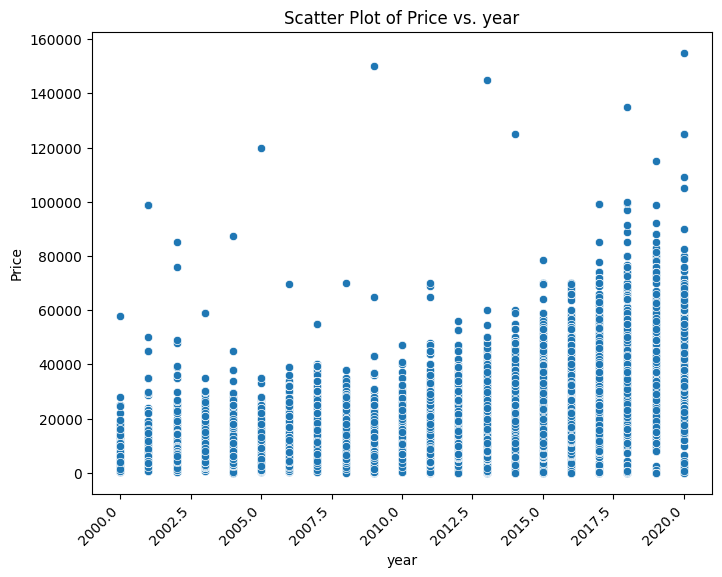

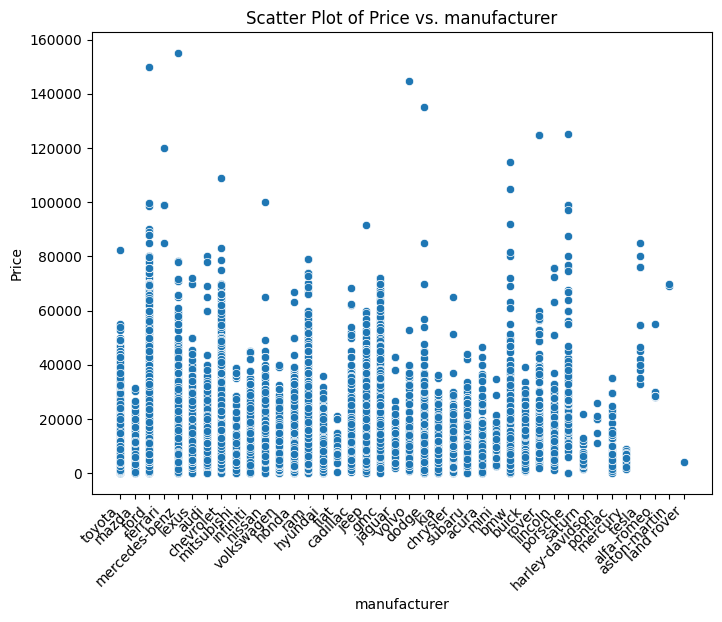

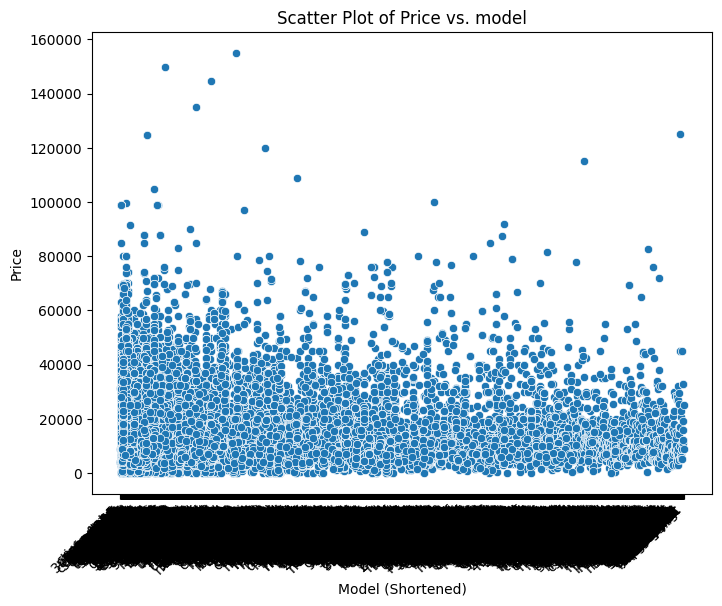

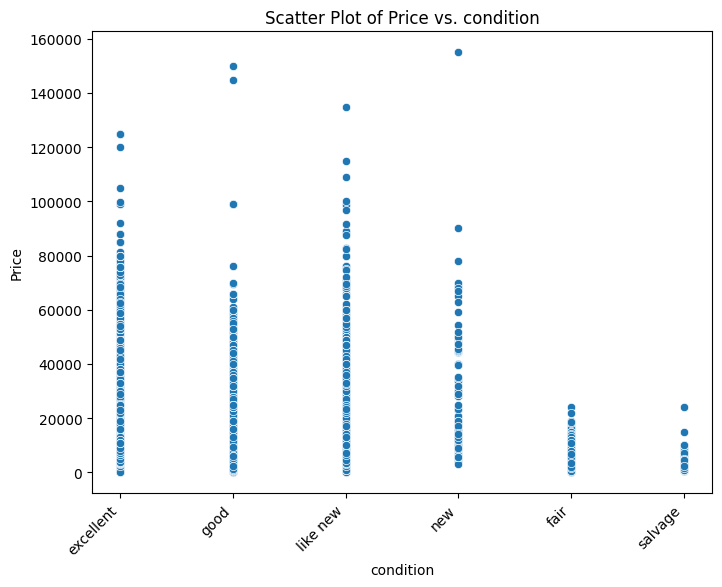

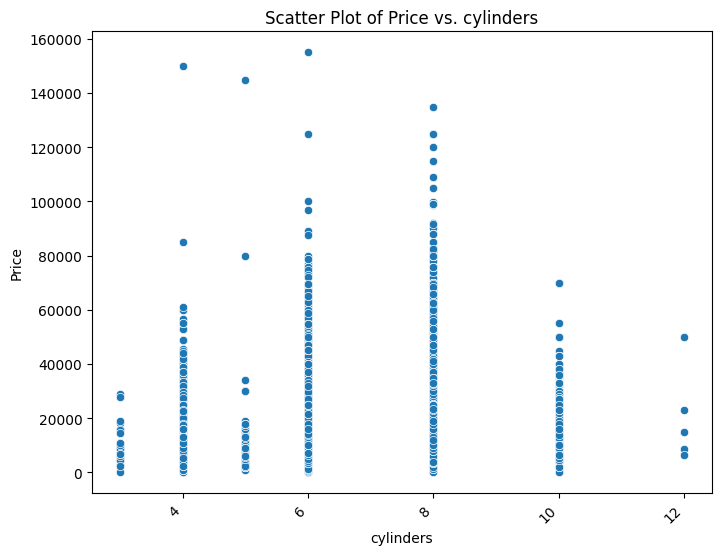

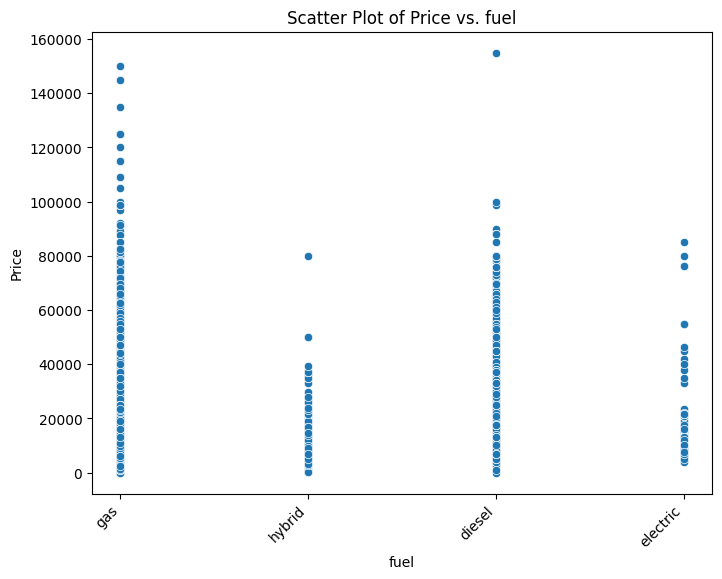

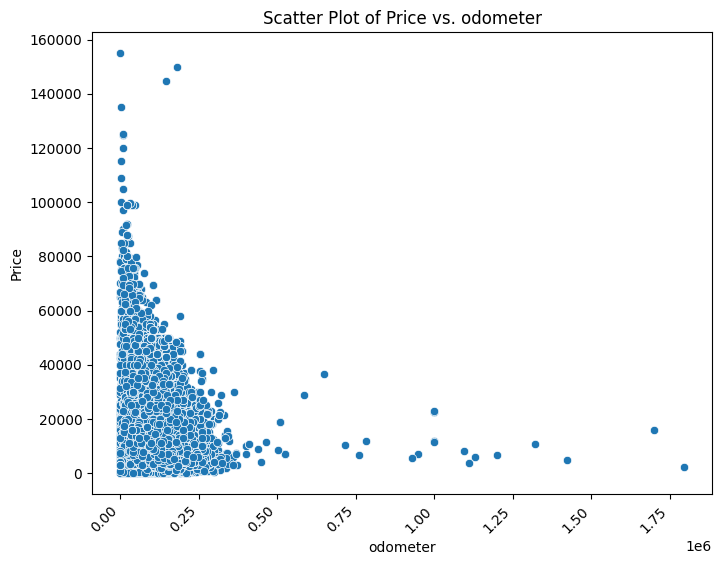

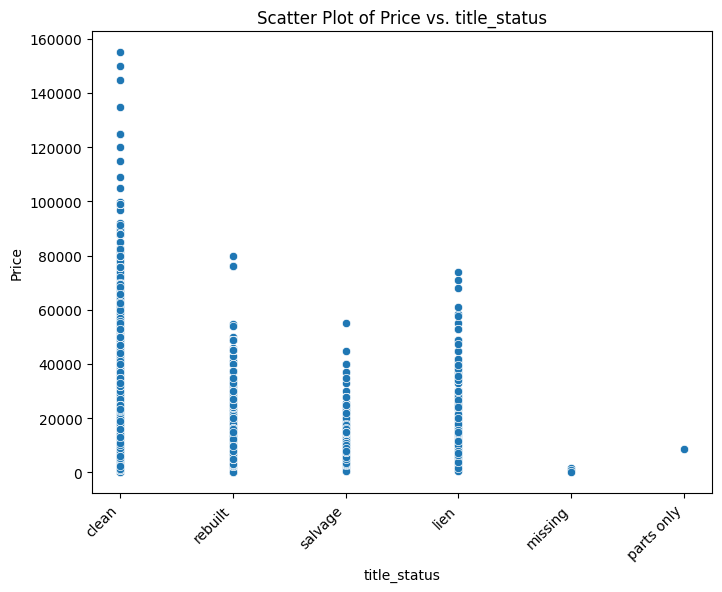

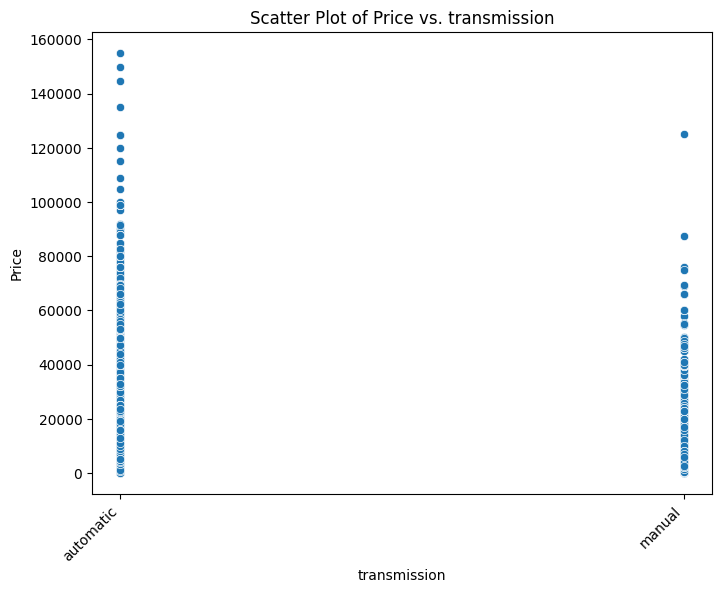

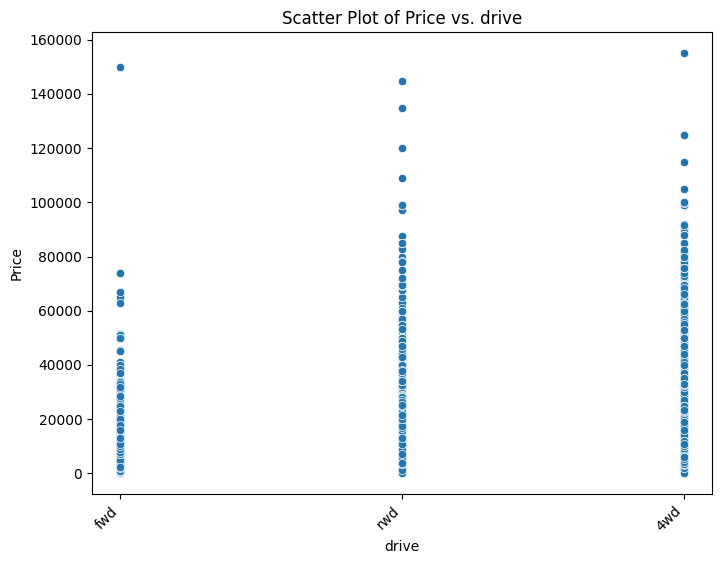

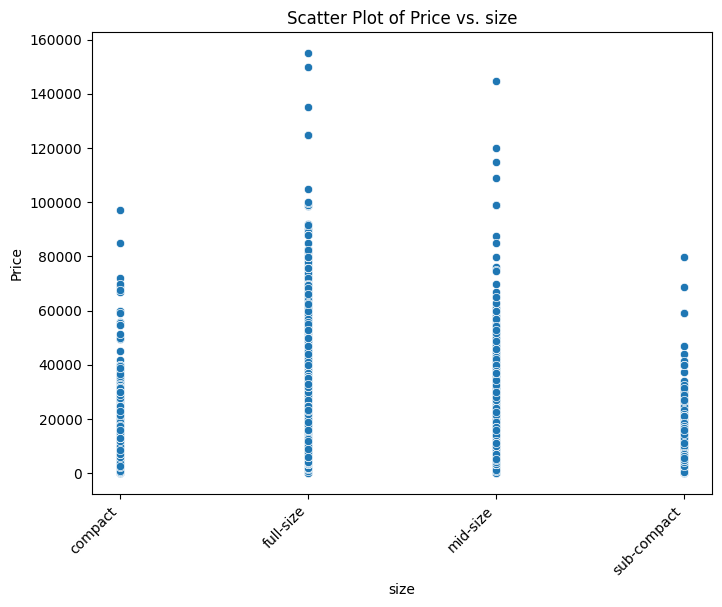

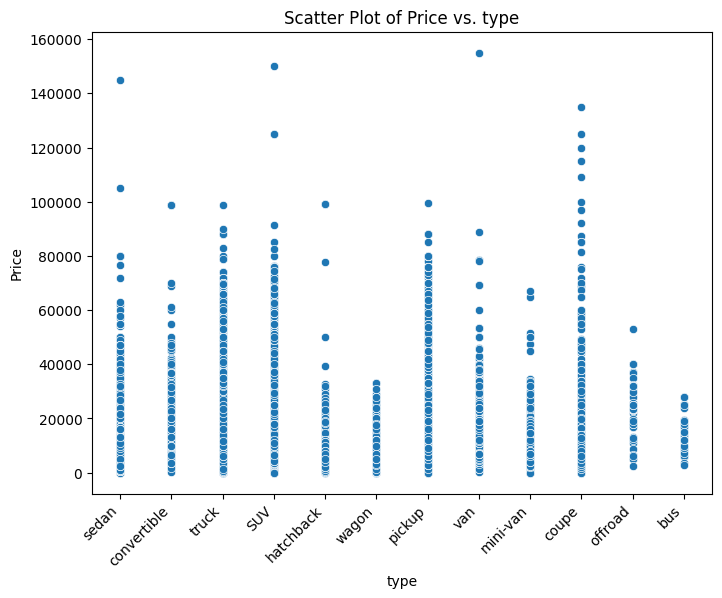

In [16]:
for column in df_cleaned.columns:
    if column != 'price':  # Skip plotting 'price' against itself
        plt.figure(figsize=(8, 6))  # Adjust figure size if needed

        # Check if the column is 'model' and if so, shorten the labels
        if column == 'model':
            # Shorten model names to the first 10 characters for better visualization
            df_cleaned['model_short'] = df_cleaned['model'].str[:10]
            sns.scatterplot(x='model_short', y='price', data=df_cleaned)
            plt.xlabel('Model (Shortened)')
        else:
            sns.scatterplot(x=column, y='price', data=df_cleaned)
            plt.xlabel(column)

        plt.title(f'Scatter Plot of Price vs. {column}')
        plt.ylabel('Price')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
        plt.show()

In [17]:
#Second Regresion Model
X = df_cleaned[['year', 'odometer', 'cylinders']]  # Select your features
y = df_cleaned['price']

# Impute missing values using SimpleImputer before model fitting
imputer = SimpleImputer(strategy='mean') # You can choose other strategies like 'median'
X = imputer.fit_transform(X)

model = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 81993607.52072173


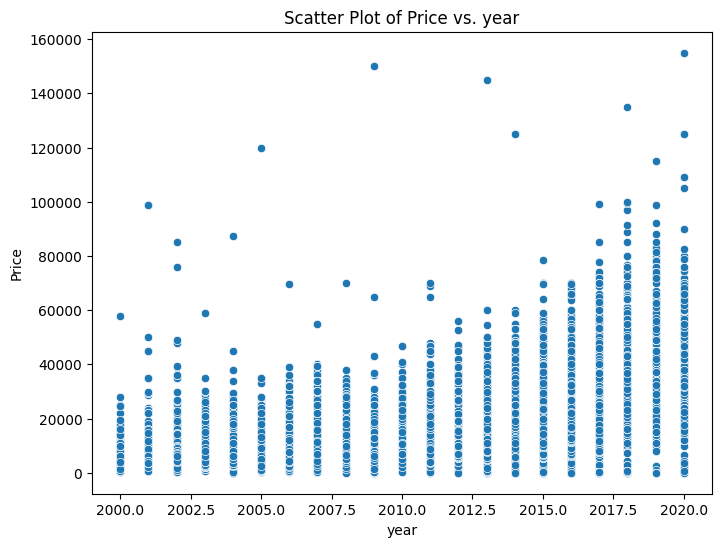

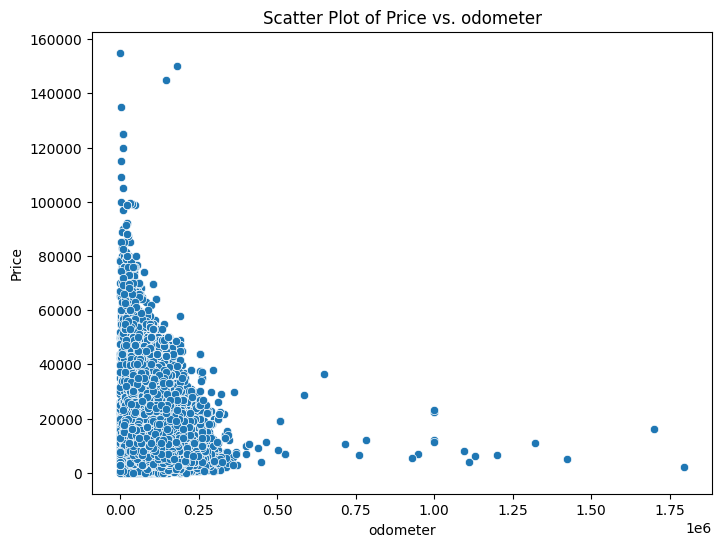

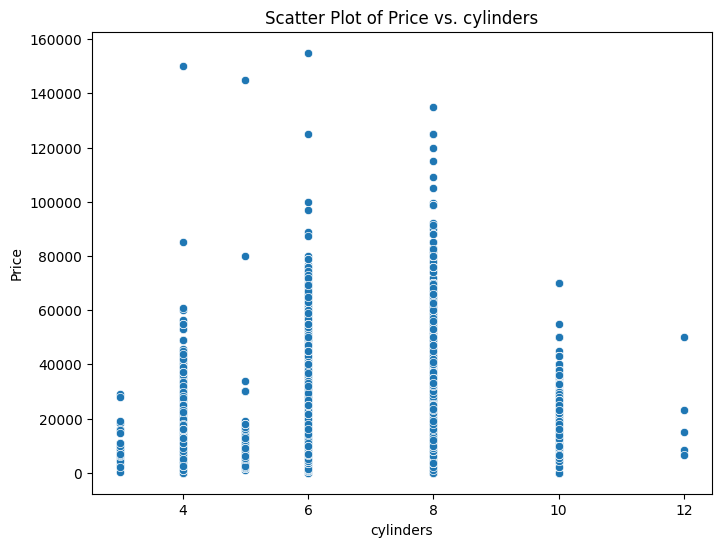

In [18]:
for column in ['year', 'odometer', 'cylinders']:
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.scatterplot(x=column, y='price', data=df_cleaned)
    plt.title(f'Scatter Plot of Price vs. {column}')
    plt.xlabel(column)
    plt.ylabel('Price')
    plt.show()

In [19]:
# 1. Define hyperparameter grid
param_grid = {
    'fit_intercept': [True, False],  # Example hyperparameters for LinearRegression
    'copy_X': [True, False],
}
# 2. Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,  # LinearRegression model
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # scoring metric
    cv=5,  # Number of cross-validation folds
)

# 3. Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# 4. Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Model: {best_model}")

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True}
Best Model: LinearRegression()


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.